In [1]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset

In [2]:
df_dn = pd.read_csv('AQI_DaNang_Done.csv')
df_hn = pd.read_csv('AQI_HaNoi_Done.csv')
df_vt = pd.read_csv('AQI_VietTri_Done.csv')
cols = ['date', 'AQI']
df_hn = df_hn[cols]
df_hn

,date,AQI
0,2019-01-01,153.571429
1,2019-01-02,133.333333
2,2019-01-03,66.000000
3,2019-01-04,138.333333
4,2019-01-05,68.000000
...,...,...
1882,2024-02-26,120.000000
1883,2024-02-27,94.000000
1884,2024-02-28,154.285714
1885,2024-02-29,108.333333


In [3]:
df_hn = pd.DataFrame(df_hn).rename(columns={"date": "ds", "AQI": "y"})
df_hn['ds'] = pd.to_datetime(df_hn['ds'])
df_hn['unique_id'] = 'series_1'
df_hn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1887 entries, 0 to 1886
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         1887 non-null   datetime64[ns]
 1   y          1887 non-null   float64       
 2   unique_id  1887 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 44.4+ KB


In [4]:
train_size_7_3 = int(0.7 * len(df_hn))
test_size_7_3 = len(df_hn) - train_size_7_3

train_data_7_3 = df_hn[:train_size_7_3]
test_data_7_3 = df_hn[train_size_7_3:].reset_index(drop=True) 

In [5]:
model = NBEATS(
    h=12,
    input_size=24,
    loss=DistributionLoss(distribution='Poisson', level=[80, 90]),
    stack_types=['identity', 'trend', 'seasonality'],
    max_steps=100,
    val_check_steps=10,
    early_stop_patience_steps=2
)

Seed set to 1


In [6]:
# Initialize the forecast object
fcst = NeuralForecast(
    models=[model],
    freq='D'
)

In [7]:
# Fit the model
fcst.fit(df=train_data_7_3,  val_size=12)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | DistributionLoss | 5     
1 | padder_train | ConstantPad1d    | 0     
2 | scaler       | TemporalNorm     | 0     
3 | blocks       | ModuleList       | 2.4 M 
--------------------------------------------------
2.4 M     Trainable params
905       Non-trainable params
2.4 M     Total params
9.789     Total estimated model params size (MB)


Epoch 59: 100%|██████████| 1/1 [00:00<00:00, 12.09it/s, v_num=79, train_loss_step=8.500, train_loss_epoch=8.500, valid_loss=3.640]


In [8]:
# Make predictions
forecasts = fcst.predict(futr_df=test_data_7_3)

c:\Users\nph17\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralforecast\core.py:758: UserWarning: Dropped 555 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.01it/s]


c:\Users\nph17\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralforecast\core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [9]:
Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
plot_df = pd.concat([test_data_7_3, Y_hat_df], axis=1)
plot_df = pd.concat([train_data_7_3, plot_df])
plot_df = plot_df.drop('unique_id', axis=1)
plot_df


,ds,y,NBEATS,NBEATS-median,NBEATS-lo-90,NBEATS-lo-80,NBEATS-hi-80,NBEATS-hi-90
0,2019-01-01,153.571429,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,133.333333,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,66.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,138.333333,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,68.000000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
562,2024-02-26,120.000000,NaN,NaN,NaN,NaN,NaN,NaN
563,2024-02-27,94.000000,NaN,NaN,NaN,NaN,NaN,NaN
564,2024-02-28,154.285714,NaN,NaN,NaN,NaN,NaN,NaN
565,2024-02-29,108.333333,NaN,NaN,NaN,NaN,NaN,NaN


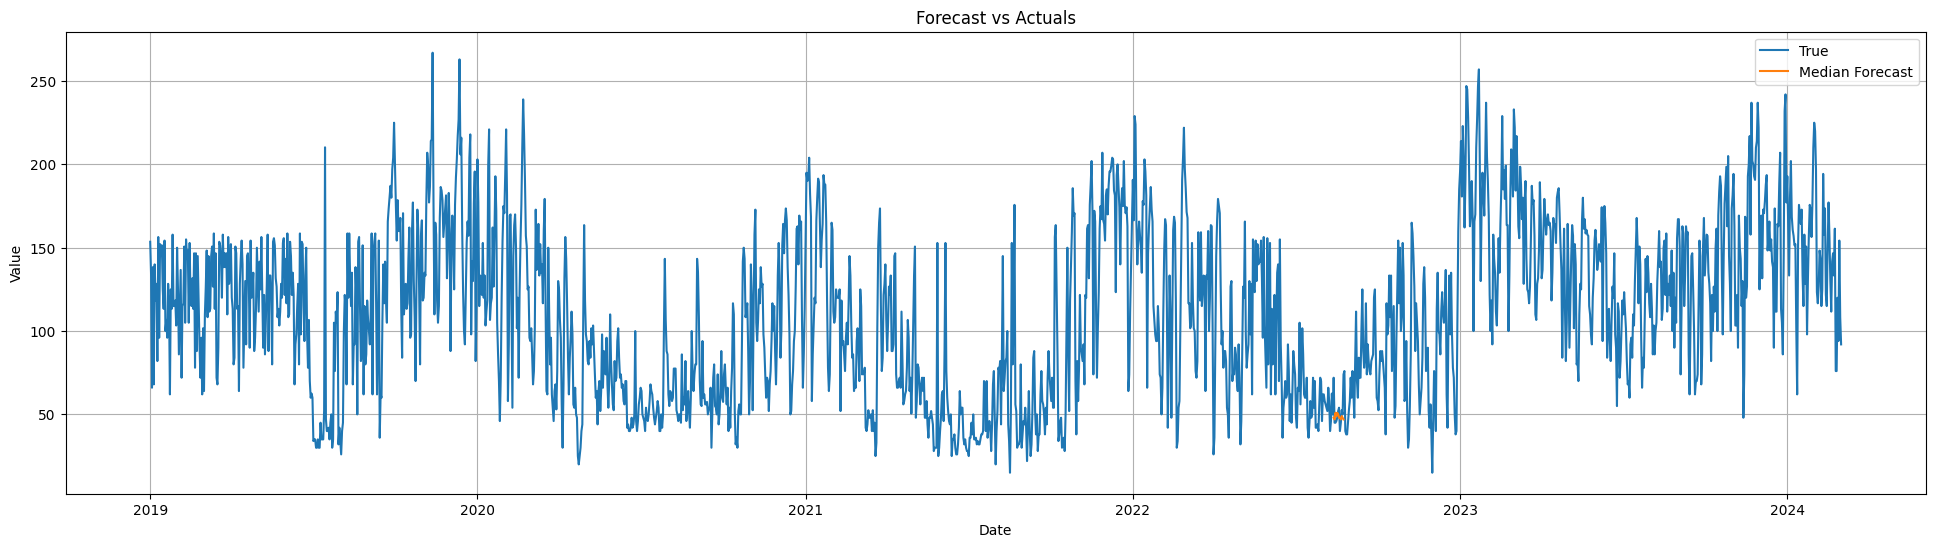

In [10]:
plt.figure(figsize=(24, 6))
plt.plot(plot_df['ds'], plot_df['y'], label='True')
plt.plot(plot_df['ds'], plot_df['NBEATS-median'], label='Median Forecast')
plt.grid()
plt.legend()
plt.title('Forecast vs Actuals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()
# plot_df

In [11]:
# Plot quantile predictions
# Y_hat_df = forecasts.reset_index(drop=False).drop(columns=['unique_id', 'ds'])
# plot_df = pd.concat([test_data_7_3, Y_hat_df], axis=1)
# plot_df = pd.concat([train_data_7_3, plot_df])

# plot_df = plot_df[plot_df.unique_id == 'series_1'].drop('unique_id', axis=1)
# plt.figure(figsize=(24, 6))
# plt.plot(plot_df['ds'], plot_df['y'], label='True')
# plt.plot(plot_df['ds'], plot_df['NBEATS-median'], label='Median Forecast')
# plt.fill_between(
#     x=plot_df['ds'][-12:],
#     y1=plot_df['NBEATS-lo-90'][-12:].values,
#     y2=plot_df['NBEATS-hi-90'][-12:].values,
#     alpha=0.4, label='Prediction Interval 90%'
# )
# plt.grid()
# plt.legend()
# plt.title('Forecast vs Actuals')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.show()

In [12]:
# # Vẽ biểu đồ
# plt.figure(figsize=(24, 6))

# # Train Data
# plt.plot(train_data_7_3['ds'], train_data_7_3['y'], label='Train Data')

# # Test Data
# plt.plot(test_data_7_3['ds'], test_data_7_3['y'], label='Test Data')

# plt.legend()
# plt.title('Forecast vs Actuals')
# plt.xlabel('Date')
# plt.ylabel('AQI')
# plt.show()
